In [104]:
import cv2
import numpy as np
import dlib
import time
import math
from Package import imutils
import csv

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:/Users/lll/Documents/hz/shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

# 获取最大的人脸
def _largest_face(dets):
    if len(dets) == 1:
        return 0

    face_areas = [ (det.right()-det.left())*(det.bottom()-det.top()) for det in dets]

    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(dets)):
        if face_areas[index] > largest_area :
            largest_index = index
            largest_area = face_areas[index]

    print("largest_face index is {} in {} faces".format(largest_index, len(dets)))

    return largest_index

# 从dlib的检测结果抽取姿态估计需要的点坐标
def get_image_points_from_landmark_shape(landmark_shape):
    if landmark_shape.num_parts != POINTS_NUM_LANDMARK:
        print("ERROR:landmark_shape.num_parts-{}".format(landmark_shape.num_parts))
        return -1, None
    
    #2D image points. If you change the image, you need to change vector
    image_points = np.array([
                                (landmark_shape.part(30).x, landmark_shape.part(30).y),     # Nose tip
                                (landmark_shape.part(8).x, landmark_shape.part(8).y),     # Chin
                                (landmark_shape.part(36).x, landmark_shape.part(36).y),     # Left eye left corner
                                (landmark_shape.part(45).x, landmark_shape.part(45).y),     # Right eye right corne
                                (landmark_shape.part(48).x, landmark_shape.part(48).y),     # Left Mouth corner
                                (landmark_shape.part(54).x, landmark_shape.part(54).y)      # Right mouth corner
                            ], dtype="double")

    return 0, image_points
    
# 用dlib检测关键点，返回姿态估计需要的几个点坐标
def get_image_points(img):
                            
    #gray = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY )  # 图片调整为灰色
    dets = detector( img, 0 )

    if 0 == len( dets ):
        print( "ERROR: found no face" )
        return -1, None
    largest_index = _largest_face(dets)
    face_rectangle = dets[largest_index]

    landmark_shape = predictor(img, face_rectangle)

    return get_image_points_from_landmark_shape(landmark_shape)


# 获取旋转向量和平移向量                        
def get_pose_estimation(img_size, image_points ):
    # 3D model points.
    model_points = np.array([
                                (0.0, 0.0, 0.0),             # Nose tip
                                (0.0, -330.0, -65.0),        # Chin
                                (-225.0, 170.0, -135.0),     # Left eye left corner
                                (225.0, 170.0, -135.0),      # Right eye right corne
                                (-150.0, -150.0, -125.0),    # Left Mouth corner
                                (150.0, -150.0, -125.0)      # Right mouth corner
                             
                            ])
     
    # Camera internals
     
    focal_length = img_size[1]
    center = (img_size[1]/2, img_size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )
     
    #print("Camera Matrix :{}".format(camera_matrix))
     
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE )
 
    #print("Rotation Vector:\n {}".format(rotation_vector))
    #print("Translation Vector:\n {}".format(translation_vector))
    return success, rotation_vector, translation_vector, camera_matrix, dist_coeffs

# 从旋转向量转换为欧拉角
def get_euler_angle(rotation_vector):
    #print(rotation_vector[0],rotation_vector[1])
    # calculate rotation angles
    theta = cv2.norm(rotation_vector, cv2.NORM_L2)
    
    # transformed to quaterniond
    w = math.cos(theta / 2)
    x = math.sin(theta / 2)*rotation_vector[0][0] / theta
    y = math.sin(theta / 2)*rotation_vector[1][0] / theta
    z = math.sin(theta / 2)*rotation_vector[2][0] / theta
    
    ysqr = y * y
    # pitch (x-axis rotation)
    t0 = 2.0 * (w * x + y * z)
    t1 = 1.0 - 2.0 * (x * x + ysqr)
    #print('t0:{}, t1:{}'.format(t0, t1))
    pitch = math.atan2(t0, t1)
    
    # yaw (y-axis rotation)
    t2 = 2.0 * (w * y - z * x)
    if t2 > 1.0:
        t2 = 1.0
    if t2 < -1.0:
        t2 = -1.0
    yaw = math.asin(t2)
    
    # roll (z-axis rotation)
    t3 = 2.0 * (w * z + x * y)
    t4 = 1.0 - 2.0 * (ysqr + z * z)
    roll = math.atan2(t3, t4)
    
    #print('pitch:{}, yaw:{}, roll:{}'.format(pitch, yaw, roll))
    
	# 单位转换：将弧度转换为度
    Y = int((pitch/math.pi)*180)
    X = int((yaw/math.pi)*180)
    Z = int((roll/math.pi)*180)
    
    return 0, Y, X, Z


# def get_pose_estimation_in_euler_angle(landmark_shape, im_szie):
#     try:
#         ret, image_points = get_image_points_from_landmark_shape(landmark_shape)
#         if ret != 0:
#             print('get_image_points failed')
#             return -1, None, None, None
    
#         ret, rotation_vector, translation_vector, camera_matrix, dist_coeffs = get_pose_estimation(im_szie, image_points)
#         if ret != True:
#             print('get_pose_estimation failed')
#             return -1, None, None, None
    
#         ret, pitch, yaw, roll = get_euler_angle(rotation_vector)
#         if ret != 0:
#             print('get_euler_angle failed')
#             return -1, None, None, None

#         euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)
#         print(euler_angle_str)
#         return 0, pitch, yaw, roll
    
#     except Exception as e:
#         print('get_pose_estimation_in_euler_angle exception:{}'.format(e))
#         return -1, None, None, None
        
with open('dir_hadaka_sugisakaya01.csv', mode='w',newline ='') as csvfile:
    fieldnames = ['Y', 'X', 'Z']
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    camera =cv2.VideoCapture("C:/Users/lll/Documents/hz/conda/Eye_detection/data/hadaka_sugisakaya01.mp4",0)

    fps = camera.get(cv2.CAP_PROP_FPS)
    print("fps",fps)
    count = 0
    while True:

        ret, im = camera.read()
        im = im[269: 1095, 1137: 1800]
        #print(ret,im)
        if not ret:
            break

        # Read Image

        if ret != True:
            print('read frame failed')
            
            continue
        size = im.shape

#         if size[0] > 700:
#             h = size[0] / 2
#             w = size[1] / 2
#             im = cv2.resize( im, (int( w ), int( h )), interpolation=cv2.INTER_CUBIC )
#             size = im.shape

        ret, image_points = get_image_points(im)
        if ret != 0:
            print('get_image_points failed')
            writer.writerow({'Y': 0, 'X':0, 'Z': 0})
            count+=1
            continue

        ret, rotation_vector, translation_vector, camera_matrix, dist_coeffs = get_pose_estimation(size, image_points)
        if ret != True:
            print('get_pose_estimation failed')

            continue

        ret, pitch, yaw, roll = get_euler_angle(rotation_vector)
        euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)
        print(euler_angle_str)
        writer.writerow({'Y': pitch, 'X':yaw, 'Z': roll})
        count+=1
        # Project a 3D point (0, 0, 1000.0) onto the image plane.
        # We use this to draw a line sticking out of the nose

        (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

        for p in image_points:
            cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)


        p1 = ( int(image_points[0][0]), int(image_points[0][1]))
        p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
        
        cv2.line(im, p1, p2, (255,0,0), 2)

        # Display image
        #cv2.putText( im, str(rotation_vector), (0, 100), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1 )
        cv2.putText( im, euler_angle_str, (0, 120), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1 )
        cv2.imshow("Output", im)
        cv2.waitKey(1)
        print("frame:",count)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    camera.release()
    cv2.destroyAllWindows()

    
#!/usr/bin/env python

fps 29.97002997002997
largest_face index is 0 in 2 faces
Y:175, X:-20, Z:-174
frame: 1
largest_face index is 1 in 2 faces
Y:174, X:-20, Z:-173
frame: 2
largest_face index is 1 in 2 faces
Y:174, X:-20, Z:-174
frame: 3
largest_face index is 0 in 2 faces
Y:-145, X:-16, Z:-6
frame: 4
largest_face index is 0 in 2 faces
Y:173, X:-18, Z:-174
frame: 5
largest_face index is 0 in 2 faces
Y:-145, X:-17, Z:-6
frame: 6
largest_face index is 1 in 2 faces
Y:-146, X:-16, Z:-6
frame: 7
largest_face index is 1 in 2 faces
Y:-145, X:-17, Z:-6
frame: 8
largest_face index is 0 in 2 faces
Y:173, X:-23, Z:-173
frame: 9
largest_face index is 1 in 2 faces
Y:-147, X:-16, Z:-5
frame: 10
largest_face index is 0 in 2 faces
Y:173, X:-25, Z:-172
frame: 11
Y:-149, X:-11, Z:-3
frame: 12
Y:-150, X:-13, Z:-4
frame: 13
Y:176, X:-23, Z:-173
frame: 14
largest_face index is 0 in 2 faces
Y:-149, X:-16, Z:-4
frame: 15
largest_face index is 0 in 2 faces
Y:175, X:-24, Z:-173
frame: 16
Y:-152, X:-17, Z:-4
frame: 17
Y:-153, X:-18,

largest_face index is 1 in 2 faces
Y:-170, X:-4, Z:-176
frame: 149
Y:-160, X:-13, Z:0
frame: 150
Y:-157, X:-10, Z:0
frame: 151
Y:-157, X:-9, Z:0
frame: 152
Y:-156, X:-8, Z:-1
frame: 153
Y:-132, X:-19, Z:-6
frame: 154
Y:-159, X:-9, Z:0
frame: 155
Y:-160, X:-9, Z:0
frame: 156
largest_face index is 1 in 2 faces
Y:-133, X:-18, Z:-6
frame: 157
Y:-155, X:-6, Z:0
frame: 158
largest_face index is 1 in 2 faces
Y:-135, X:-19, Z:-6
frame: 159
Y:-158, X:-10, Z:0
frame: 160
Y:-159, X:-5, Z:0
frame: 161
Y:-162, X:-8, Z:0
frame: 162
largest_face index is 1 in 2 faces
Y:-134, X:-21, Z:-9
frame: 163
Y:-163, X:-17, Z:-1
frame: 164
largest_face index is 1 in 3 faces
Y:-137, X:-26, Z:-12
frame: 165
largest_face index is 1 in 2 faces
Y:-172, X:-1, Z:10
frame: 166
largest_face index is 1 in 2 faces
Y:-173, X:-1, Z:9
frame: 167
largest_face index is 2 in 3 faces
Y:-135, X:-27, Z:-12
frame: 168
largest_face index is 2 in 3 faces
Y:-138, X:-28, Z:-11
frame: 169
largest_face index is 1 in 2 faces
Y:-174, X:15, 

Y:176, X:-26, Z:-24
frame: 331
Y:177, X:-24, Z:-24
frame: 332
Y:176, X:-28, Z:-23
frame: 333
Y:177, X:-25, Z:-23
frame: 334
ERROR: found no face
get_image_points failed
Y:175, X:-20, Z:-22
frame: 336
Y:173, X:-25, Z:-20
frame: 337
Y:172, X:-25, Z:-21
frame: 338
Y:172, X:-25, Z:-19
frame: 339
ERROR: found no face
get_image_points failed
Y:171, X:-25, Z:-18
frame: 341
Y:171, X:-24, Z:-18
frame: 342
Y:170, X:-23, Z:-18
frame: 343
Y:171, X:-22, Z:-18
frame: 344
ERROR: found no face
get_image_points failed
Y:170, X:-21, Z:-17
frame: 346
ERROR: found no face
get_image_points failed
Y:169, X:-19, Z:-18
frame: 348
Y:169, X:-17, Z:-18
frame: 349
Y:169, X:-18, Z:-17
frame: 350
ERROR: found no face
get_image_points failed
Y:167, X:-18, Z:-16
frame: 352
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
Y:165, X:-24, Z:-13
frame: 355
Y:165, X:-23, Z:-12
frame: 356
Y:165, X:-20, Z:-13
frame: 357
ERROR: found no face
get_image_points failed
ERROR: found no face

ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
Y:-174, X:-8, Z:-9
frame: 547
Y:-174, X:-9, Z:-9
frame: 548
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points failed
ERROR: found no face
get_image_points fa

KeyboardInterrupt: 

In [68]:
# for line in open("C:/Users/lll/Documents/hz/conda/Eye_detection/head_example_Take_001.txt"):
#     for num in line:
#         print(num)
file=open('C:/Users/lll/Documents/hz/conda/Eye_detection/ikari30_Take_001.txt','r')
with open('origin_iraki_frame.csv', mode='w',newline ='') as csvfile:
    fieldnames = ['Z', 'X', 'Y']
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    result=list()
    for c in file.readlines():
        c_array=c.split(" ")
#       result.append(c_array[0])
        print(c_array[3])
        writer.writerow({'Z': c_array[3], 'X':c_array[4], 'Y': c_array[5]})
#print(result)

-35.8699
-41.1945
-45.4707
-48.5138
-50.4047
-51.3973
-51.7709
-51.8715
-51.966
-52.0605
-51.9601
-51.6877
-51.5118
-51.7301
-52.2023
-52.5849
-52.6669
-52.5947
-52.6583
-52.9903
-53.4067
-53.5357
-53.0384
-51.8628
-50.1943
-48.1832
-45.7878
-43.1419
-40.8466
-39.6558
-39.9202
-41.4505
-43.828
-46.5997
-49.3357
-51.6884
-53.4609
-54.7486
-55.6845
-56.4533
-57.05
-57.3843
-57.6097
-57.9854
-58.6003
-59.3155
-60.0199
-60.9386
-62.4614
-64.7418
-67.2226
-68.9454
-69.223
-68.105
-66.1193
-63.7758
-61.3036
-58.6493
-55.753
-52.8099
-50.2657
-48.1536
-45.8182
-42.5206
-37.9964
-32.6734
-27.1639
-21.7965
-16.54
-11.1417
-5.12335
1.82415
9.11063
15.363
19.6883
22.4652
24.6571
26.8874
29.2274
31.6675
34.1574
36.6078
38.8385
40.961
43.2085
45.7005
48.2633
50.6977
52.8968
54.7943
56.3839
57.6072
58.6984
59.865
61.1227
62.306
63.2373
63.9628
64.6831
65.4438
65.9687
65.912
65.2452
64.4579
64.173
64.6041
65.404
66.1549
66.8036
67.5229
68.3043
68.795
68.683
68.0879
67.4601
67.1954
67.2566
67.2197
66.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.interpolate import spline

import scipy.signal as signal
from sklearn import preprocessing


def smoothing(joint):   
    
    len_x = 1500
    list_x = np.arange(len_x)

    # Local variables
    x = []
    y = []


    x_sm =list_x
    y_sm =joint

    x_smooth = np.linspace(0,1500, 300)
    y_smooth = spline(x_sm, y_sm, x_smooth)
    plt.figure(figsize=(16,8))
    plt.plot(y_smooth, label = 'Eyesight')
    plt.show()
    return x_smooth,y_smooth
    

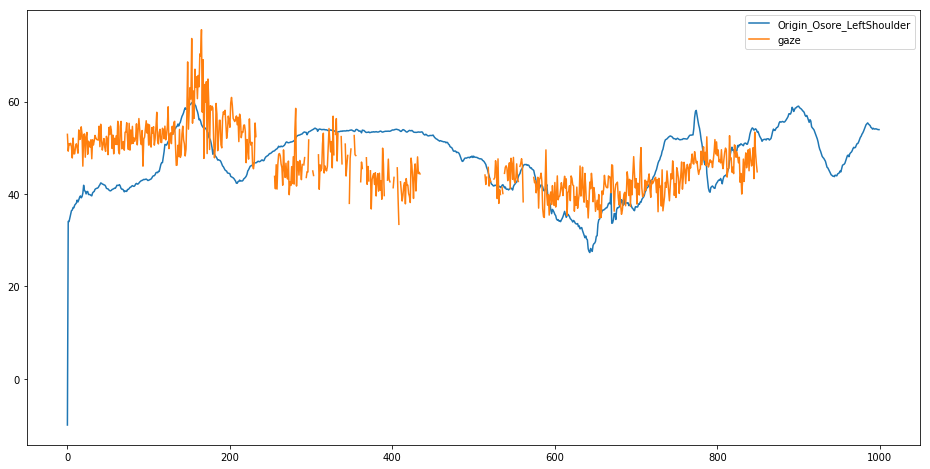

In [120]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from pandas import read_csv
import pandas as pd
orgin_head = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/data/sigisakaya_01_neck_transfer.csv")
#orgin_neck = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/data/kanashima_Neck_transfer.csv")
head = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/hadaka_sugisakaya01_gaze_ratio.csv")
#0.
face_dir = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/dir_hadaka_sugisakaya01.csv")
#orgin_neck = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/player_ikari30_neck_frame.csv")
#head['f2Y'] = np.where(f2['Y']>=0,50,0)
plt.figure(figsize=(16,8))
#plt.plot(orgin_head["Y"], label = 'yorgin_head')
#plt.plot(head["Y"], label = 'yhead')
plt.plot(orgin_head["LeftShoulder_xr"][0:1000]+80, label = 'Origin_Osore_LeftShoulder')#LeftShoulder_xp
#x_smooth,y_smooth = smoothing(head["ratio"][2500:4000]*100)

#plt.plot(head["left"][0:1000], label = 'X')
plt.plot(head["ratio"][0:1000]*60, label = 'gaze')
#plt.plot(head["ratio"][2500:4000]*100, label = 'Eyesight')
#plt.plot(orgin_head["Z"], label = 'zorgin_head')
#plt.plot(head["Z"], label = 'zhead')
#plt.plot(orgin_neck["X"], label = 'origin_neck')

plt.legend()
plt.show()

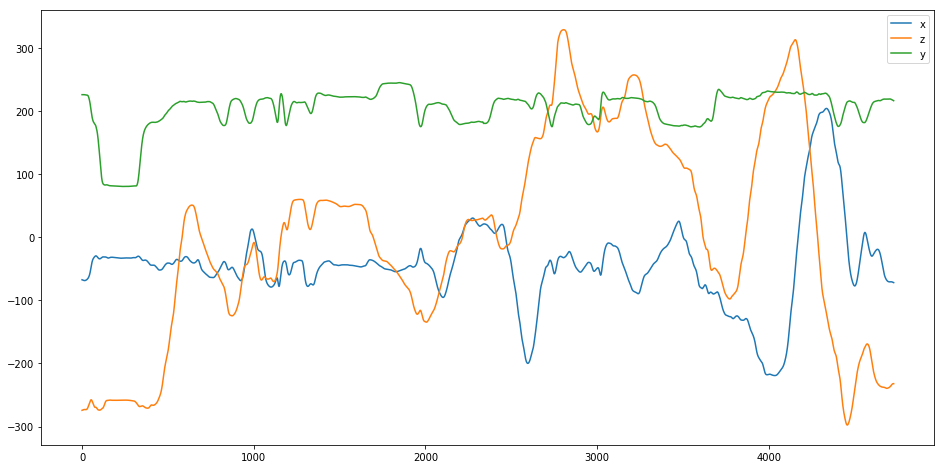

In [13]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from pandas import read_csv
import pandas as pd
orgin_head = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/data/yuya_elbow_transfer.csv")
#orgin_neck = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/data/kanashima_Neck_transfer.csv")
head = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/data/yuya_leftKnee_transfer.csv")
#orgin_neck = pd.read_csv("C:/Users/lll/Documents/hz/conda/Eye_detection/player_ikari30_neck_frame.csv")
#head['f2Y'] = np.where(f2['Y']>=0,50,0)
plt.figure(figsize=(16,8))
#plt.plot(orgin_head["Y"], label = 'yorgin_head')
#plt.plot(head["Y"], label = 'yhead')
plt.plot(orgin_head["LeftShoulder_xp"], label = 'x')#LeftShoulder_xp
plt.plot(orgin_head["LeftShoulder_zp"], label = 'z')#LeftShoulder_xp
plt.plot(orgin_head["LeftShoulder_yp"], label = 'y')#LeftShoulder_xp
#plt.plot(orgin_neck["LeftShoulder_xr"], label = 'orgin_neck')
#plt.plot(head["LeftShoulder_xp"], label = 'Eyesight')
#plt.plot(orgin_head["Z"], label = 'zorgin_head')
#plt.plot(head["Z"], label = 'zhead')
#plt.plot(orgin_neck["X"], label = 'origin_neck')

plt.legend()
plt.show()

In [41]:
head["ratio"][1000:2000].shape

(930,)